## 1. 数据加载与探索

In [33]:
from sklearn.datasets import fetch_20newsgroups

# 加载数据集并查看样本
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
train_dataset_raw = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
test_dataset_raw = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

sample = {
    "text_preview": train_dataset_raw.data[0][:200],
    "label": train_dataset_raw.target_names[train_dataset_raw.target[0]],
}
sample


{'text_preview': 'From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard',
 'label': 'comp.graphics'}

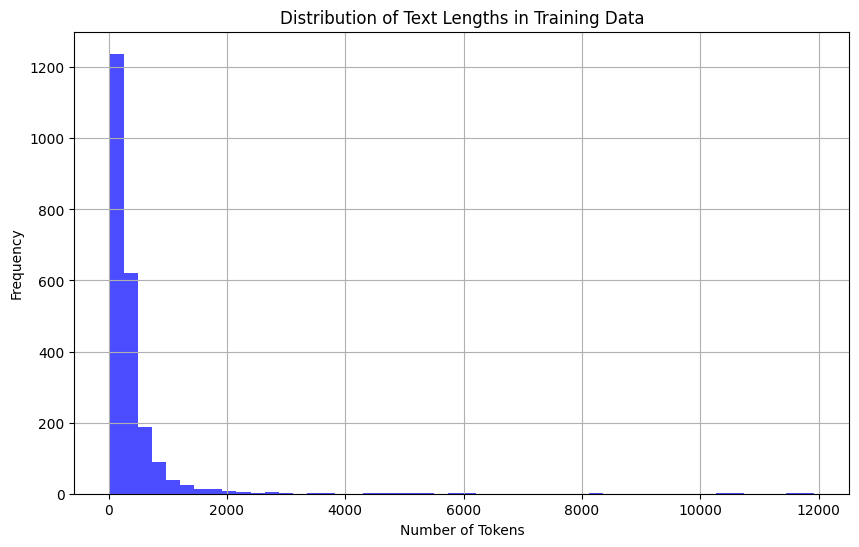

In [34]:
import re
import matplotlib.pyplot as plt

# 训练集文本长度分布

def basic_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9(),.!?\'`]", " ", text)
    text = re.sub(r"([,.!?\'`])", r" \1 ", text)
    return text.strip().split()

train_text_lengths = [len(basic_tokenize(text)) for text in train_dataset_raw.data]

plt.figure(figsize=(10, 6))
plt.hist(train_text_lengths, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Text Lengths in Training Data')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


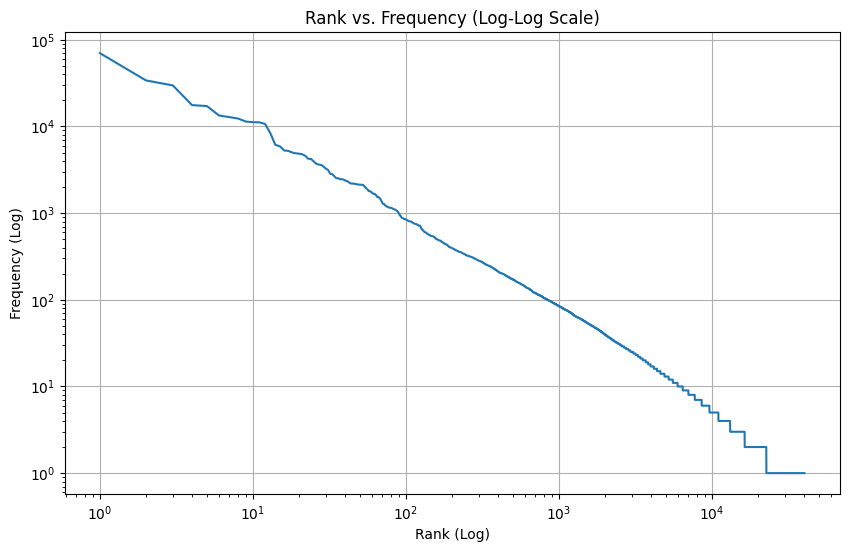

In [35]:
from collections import Counter
import numpy as np

# 计算所有词元的频率
word_counts = Counter()
for text in train_dataset_raw.data:
    word_counts.update(basic_tokenize(text))

# 获取频率并按降序排序
frequencies = sorted(word_counts.values(), reverse=True)
# 生成排名
ranks = np.arange(1, len(frequencies) + 1)

# 绘制对数坐标图
plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies)
plt.title('Rank vs. Frequency (Log-Log Scale)')
plt.xlabel('Rank (Log)')
plt.ylabel('Frequency (Log)')
plt.grid(True)
plt.show()



## 2. 定义所需组件

In [36]:
from transformers import BertTokenizer

# 使用 Hugging Face 的 Tokenizer
# 20newsgroups是英文数据集，我们使用bert-base-uncased
bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

# 查看一下特殊token和词汇表大小
print(f"UNK token: '{tokenizer.unk_token}', ID: {tokenizer.unk_token_id}")
print(f"PAD token: '{tokenizer.pad_token}', ID: {tokenizer.pad_token_id}")
print(f"CLS token: '{tokenizer.cls_token}', ID: {tokenizer.cls_token_id}")
print(f"SEP token: '{tokenizer.sep_token}', ID: {tokenizer.sep_token_id}")
print(f"Vocab size: {tokenizer.vocab_size}")


UNK token: '[UNK]', ID: 100
PAD token: '[PAD]', ID: 0
CLS token: '[CLS]', ID: 101
SEP token: '[SEP]', ID: 102
Vocab size: 30522


In [37]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm import tqdm

class BertTextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.processed_data = []

        for text, label in tqdm(zip(texts, labels), total=len(labels), desc="Processing Dataset"):
            # BertTokenizer的`__call__`方法会返回一个包含input_ids, token_type_ids, attention_mask的字典
            # 我们这里不进行截断，后面处理超长文本
            encoding = self.tokenizer(text, add_special_tokens=True, truncation=False)
            input_ids = encoding['input_ids']
            
            # 遵循原代码逻辑，对超长文本进行切片
            if len(input_ids) <= self.max_len:
                self.processed_data.append({"input_ids": input_ids, "label": label})
            else:
                stride = max(1, int(self.max_len * 0.8))
                # CLS和SEP token已经包含在内，所以切片时要注意
                for i in range(0, len(input_ids) - self.max_len + 1, stride):
                    chunk = input_ids[i:i + self.max_len]
                    self.processed_data.append({"input_ids": chunk, "label": label})
    
    def __len__(self):
        return len(self.processed_data)

    def __getitem__(self, idx):
        return self.processed_data[idx]


In [38]:
def bert_collate_fn(batch):
    max_batch_len = max(len(item["input_ids"]) for item in batch)
    
    batch_input_ids, batch_attention_masks, batch_labels = [], [], []

    for item in batch:
        input_ids = item["input_ids"]
        padding_len = max_batch_len - len(input_ids)
        
        # padding token的id在bert tokenizer中是0
        padded_ids = input_ids + [tokenizer.pad_token_id] * padding_len
        # attention mask：1表示是真实token，0表示是padding
        attention_mask = [1] * len(input_ids) + [0] * padding_len
        
        batch_input_ids.append(padded_ids)
        batch_attention_masks.append(attention_mask)
        batch_labels.append(item["label"])
        
    return {
        "input_ids": torch.tensor(batch_input_ids, dtype=torch.long),
        "attention_mask": torch.tensor(batch_attention_masks, dtype=torch.long),
        "labels": torch.tensor(batch_labels, dtype=torch.long),
    }


In [39]:
from torch.utils.data import DataLoader

train_dataset = BertTextClassificationDataset(train_dataset_raw.data, train_dataset_raw.target, tokenizer, max_len=128)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=bert_collate_fn) # BERT模型较大，batch_size调小一些

valid_dataset = BertTextClassificationDataset(test_dataset_raw.data, test_dataset_raw.target, tokenizer, max_len=128)
valid_loader = DataLoader(valid_dataset, batch_size=16, collate_fn=bert_collate_fn)

{"train_samples": len(train_dataset), "valid_samples": len(valid_dataset), "batch_size": 16}


Processing Dataset: 100%|██████████| 1502/1502 [00:09<00:00, 166.32it/s]


{'train_samples': 9992, 'valid_samples': 7457, 'batch_size': 16}

## 3. 构建模型


In [40]:
from transformers import BertModel

class TextClassifierBERT(nn.Module):
    def __init__(self, model_name, num_classes, freeze_bert=False):
        super(TextClassifierBERT, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # bert的输出是一个元组，第一个元素是last_hidden_state，第二个是pooler_output
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # 我们使用[CLS] token对应的输出(pooler_output)来进行分类
        pooled_output = outputs.pooler_output
        
        logits = self.classifier(pooled_output)
        return logits


In [41]:
import os
import json
from tqdm import tqdm

class Trainer:
    def __init__(self, model, optimizer, criterion, train_loader, valid_loader, device, output_dir="."):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.device = device
        self.best_accuracy = 0.0
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)
        self.train_losses = []
        self.val_accuracies = []

    def _run_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        for batch in tqdm(self.train_loader, desc=f"Epoch {epoch+1} [训练中]"):
            self.optimizer.zero_grad()
            
            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device)
            
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            loss = self.criterion(outputs, labels)
            total_loss += loss.item()
            
            loss.backward()
            self.optimizer.step()
        
        return total_loss / len(self.train_loader)

    def _evaluate(self, epoch):
        self.model.eval()
        correct_preds = 0
        total_samples = 0
        with torch.no_grad():
            for batch in tqdm(self.valid_loader, desc=f"Epoch {epoch+1} [评估中]"):
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)
                
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                _, predicted = torch.max(outputs, 1)
                
                total_samples += labels.size(0)
                correct_preds += (predicted == labels).sum().item()
        
        return correct_preds / total_samples

    def _save_checkpoint(self, epoch, val_accuracy):
        if val_accuracy > self.best_accuracy:
            self.best_accuracy = val_accuracy
            # 对于transformers模型，推荐使用save_pretrained来保存
            self.model.bert.save_pretrained(self.output_dir)
            # 单独保存分类头
            classifier_path = os.path.join(self.output_dir, "classifier.pth")
            torch.save(self.model.classifier.state_dict(), classifier_path)
            
            print(f"新最佳模型已保存! Epoch: {epoch+1}, 验证集准确率: {val_accuracy:.4f}")

    def train(self, epochs, tokenizer, label_map):
        self.train_losses = []
        self.val_accuracies = []
        for epoch in range(epochs):
            avg_loss = self._run_epoch(epoch)
            val_accuracy = self._evaluate(epoch)
            
            self.train_losses.append(avg_loss)
            self.val_accuracies.append(val_accuracy)
            
            print(f"Epoch {epoch+1}/{epochs} | 训练损失: {avg_loss:.4f} | 验证集准确率: {val_accuracy:.4f}")
            
            self._save_checkpoint(epoch, val_accuracy)
        
        print("训练完成！")
        # tokenizer也可以保存
        tokenizer.save_pretrained(self.output_dir)
           
        labels_path = os.path.join(self.output_dir, 'label_map.json')
        with open(labels_path, 'w', encoding='utf-8') as f:
           json.dump(label_map, f, ensure_ascii=False, indent=4)
        print(f"Tokenizer 和标签映射 ({labels_path}) 已保存。")
        return self.train_losses, self.val_accuracies


In [42]:
class Predictor:
    def __init__(self, model, tokenizer, label_map, device, max_len=128):
        self.model = model.to(device)
        self.model.eval()
        self.tokenizer = tokenizer
        self.label_map = label_map
        self.id_to_label = {int(idx): label for label, idx in self.label_map.items()}
        self.device = device
        self.max_len = max_len

    def predict(self, text):
        # 使用bert tokenizer进行分词，但不截断
        encoding = self.tokenizer(text, add_special_tokens=True, truncation=False)
        token_ids = encoding['input_ids']

        # 同样的分块逻辑
        chunks, chunk_masks = [], []
        if len(token_ids) <= self.max_len:
            chunks.append(token_ids)
        else:
            stride = max(1, int(self.max_len * 0.8))
            for i in range(0, len(token_ids) - self.max_len + 1, stride):
                chunks.append(token_ids[i:i + self.max_len])
        
        if not chunks:
            return "无法预测（文本过短或分词后为空）"

        # 对分块进行padding
        max_chunk_len = max(len(c) for c in chunks)
        
        padded_chunks, attention_masks = [], []
        for chunk in chunks:
            padding_len = max_chunk_len - len(chunk)
            padded_chunks.append(chunk + [self.tokenizer.pad_token_id] * padding_len)
            attention_masks.append([1] * len(chunk) + [0] * padding_len)
            
        # 转换为tensor
        input_ids_tensor = torch.tensor(padded_chunks, dtype=torch.long).to(self.device)
        attention_mask_tensor = torch.tensor(attention_masks, dtype=torch.long).to(self.device)
        
        # 批量推理所有分块
        with torch.no_grad():
            outputs = self.model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
            preds = torch.argmax(outputs, dim=1)

        # 投票得出最终结果
        final_pred_id = torch.bincount(preds).argmax().item()
        
        final_pred_label = self.id_to_label[final_pred_id]
        return final_pred_label


## 4. 训练模型


In [43]:
# 超参数
hparams = {
    "model_name": 'bert-base-uncased',
    "num_classes": len(train_dataset_raw.target_names),
    "freeze_bert": False, # 是否冻结bert层
    "epochs": 5, # BERT微调通常不需要太多epoch
    "learning_rate": 2e-5, # BERT微调常用的学习率
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "output_dir": "output_bert"
}

# 实例化
model = TextClassifierBERT(
    model_name=hparams["model_name"], 
    num_classes=hparams["num_classes"],
    freeze_bert=hparams["freeze_bert"]
).to(hparams["device"])

criterion = nn.CrossEntropyLoss()
# 对于微调，通常只优化分类头的参数或者使用更小的学习率优化bert参数
optimizer = torch.optim.Adam(model.parameters(), lr=hparams["learning_rate"])
hparams


{'model_name': 'bert-base-uncased',
 'num_classes': 4,
 'freeze_bert': False,
 'epochs': 5,
 'learning_rate': 2e-05,
 'device': 'cuda',
 'output_dir': 'output_bert'}

In [44]:
trainer = Trainer(
    model, 
    optimizer, 
    criterion, 
    train_loader, 
    valid_loader, 
    hparams["device"], 
    output_dir=hparams["output_dir"]
)

label_map = {name: i for i, name in enumerate(train_dataset_raw.target_names)}

bert_train_losses, bert_val_accuracies = trainer.train(epochs=hparams["epochs"], tokenizer=tokenizer, label_map=label_map)


Epoch 1 [评估中]: 100%|██████████| 467/467 [00:29<00:00, 16.02it/s]


Epoch 1/5 | 训练损失: 0.4214 | 验证集准确率: 0.8738
新最佳模型已保存! Epoch: 1, 验证集准确率: 0.8738


Epoch 2 [评估中]: 100%|██████████| 467/467 [00:31<00:00, 14.84it/s]


Epoch 2/5 | 训练损失: 0.1495 | 验证集准确率: 0.8827
新最佳模型已保存! Epoch: 2, 验证集准确率: 0.8827


Epoch 3 [评估中]: 100%|██████████| 467/467 [00:31<00:00, 14.66it/s]


Epoch 3/5 | 训练损失: 0.0698 | 验证集准确率: 0.8915
新最佳模型已保存! Epoch: 3, 验证集准确率: 0.8915


Epoch 4 [评估中]: 100%|██████████| 467/467 [00:32<00:00, 14.44it/s]


Epoch 4/5 | 训练损失: 0.0404 | 验证集准确率: 0.8946
新最佳模型已保存! Epoch: 4, 验证集准确率: 0.8946


Epoch 5 [评估中]: 100%|██████████| 467/467 [00:32<00:00, 14.48it/s]


Epoch 5/5 | 训练损失: 0.0251 | 验证集准确率: 0.9032
新最佳模型已保存! Epoch: 5, 验证集准确率: 0.9032
训练完成！
Tokenizer 和标签映射 (output_bert\label_map.json) 已保存。


In [45]:
def plot_history(train_losses, val_accuracies, title_prefix=""):
    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Training Loss
    ax1.plot(epochs, train_losses, 'bo-', label='Training Loss')
    ax1.set_title(f'{title_prefix} Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.legend()
    
    # Plot Validation Accuracy
    ax2.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    ax2.set_title(f'{title_prefix} Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    ax2.legend()
    
    plt.suptitle(f'{title_prefix} Training and Validation Metrics', fontsize=16)
    plt.show()


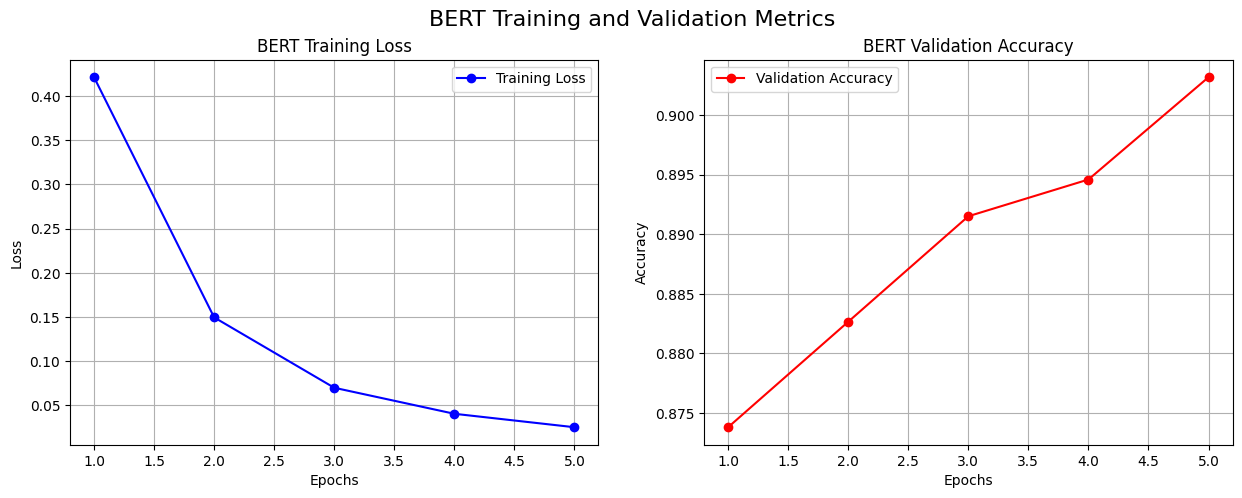

In [46]:
plot_history(bert_train_losses, bert_val_accuracies, title_prefix="BERT")


## 5. 模型推理


In [47]:
# 加载资源
labels_path = os.path.join(hparams["output_dir"], 'label_map.json')
with open(labels_path, 'r', encoding='utf-8') as f:
    label_map_loaded = json.load(f)

# 实例化推理组件
inference_tokenizer = BertTokenizer.from_pretrained(hparams["output_dir"])

inference_model = TextClassifierBERT(
    model_name=hparams["output_dir"], # 从保存的目录加载bert
    num_classes=len(label_map_loaded)
).to(hparams["device"])

# 加载分类头的权重
classifier_path = os.path.join(hparams["output_dir"], "classifier.pth")
inference_model.classifier.load_state_dict(torch.load(classifier_path, map_location=hparams["device"]))


<All keys matched successfully>

In [48]:
predictor = Predictor(
    inference_model, 
    inference_tokenizer, 
    label_map_loaded, 
    hparams["device"]
)

# 预测
new_text = "The doctor prescribed a new medicine for the patient's illness, focusing on its gpu accelerated healing properties."
predicted_class = predictor.predict(new_text)

{"text": new_text, "pred": predicted_class}


{'text': "The doctor prescribed a new medicine for the patient's illness, focusing on its gpu accelerated healing properties.",
 'pred': 'sci.med'}